# Evaluation of 1/8° 4DVarNet (trained on GF with 7 nadirs)

## 0. Introduction

### 0.1 Data Resolution

The case studied in this notebook is that of a 4DVarNet model trained on GF
region (eNATL60 data) at 1/8th resolution.

For comparison purposes with other methods, the reconstructed SSH fields are
resized to 1/20th resolution before computing the metrics.

### 0.2 Patch size & Reconstruction

The method's input training data are split into patches of size
$(\text{time}, \text{latitude}, \text{longitude}) = (15, 136, 136)$,
corresponding to a temporal evolution over 15 days on a $17° \times 17°$ domain.

The extra $1°$ on each side is due to the prevention of side effects during
the training.

Finally, the reconstructed SSH fields are obtained by stitching each patch; the
extra $1°$ on each side is removed so that the metrics are indeed computed on a
$15° \times 15°$ mesh grid.

See the [repository of 4dvarnet-starter](https://github.com/CIA-Oceanix/4dvarnet-starter)
for further details.

In [1]:
import logging
import os
import sys
import warnings
warnings.filterwarnings('ignore')

import dask
import hvplot.xarray
import numpy as np
import pandas as pd
import xarray as xr
import xrft

sys.path.append('..')
logger = logging.getLogger()
logger.disabled = True

from src.mod_eval import psd_based_scores, rmse_based_scores
from src.mod_plot import plot_psd_score, plot_psd_score_seasonal

In [2]:
for pck in (xr, np, hvplot, dask, logging, xrft):
    print(pck.__name__, pck.__version__)

xarray 2024.2.0
numpy 1.26.4
hvplot 0.9.2
dask 2024.4.0
logging 0.5.1.2
xrft 1.0.1


In [3]:
# Season time range for seasonal evaluation
whole_year = slice('2012-10-21', '2013-09-10')
mid_autumn = slice('2012-10-21', '2012-11-30')
mid_winter = slice('2013-02-01', '2013-03-13')
mid_spring = slice('2013-04-30', '2013-06-09')
mid_summer = slice('2013-07-11', '2013-08-20')

# Domain delimitation (Gulfstream/GF)
ranges = {
    'GF': dict(lon=(-64., -49.), lat=(29., 44.)),
    'GRE': dict(lon=(-39., -24), lat=(49, 64)),
    'MAD': dict(lon=(-27., -12.), lat=(29., 44.)),
}

##  1. Input files

### 1.1 Read nature run SSH for mapping evaluation

In [4]:
if not os.path.exists('../ds_ref/ds_ref_1_20.nc'):
    os.makedirs('../ds_ref/', exist_ok=True)
    print('ds_ref file not found...\nDownload it...')
    !wget -O ../ds_ref/ds_ref_1_20.nc https://s3.eu-central-1.wasabisys.com/melody/data_challenge_Daniel_Guillaume/public/dc_ref/NATL60-CJM165-daily-reg-1_20.nc

ds_ref = (
    xr.open_dataset('../ds_ref/ds_ref_1_20.nc')[['ssh']]
    .sel(time=whole_year)
)
ds_ref

<xarray.Dataset> Size: 9GB
Dimensions:  (time: 325, lat: 1242, lon: 2803)
Coordinates:
  * lat      (lat) float64 10kB 5.95 6.0 6.05 6.1 6.15 ... 67.85 67.9 67.95 68.0
  * lon      (lon) float64 22kB -98.05 -98.0 -97.95 -97.9 ... 41.95 42.0 42.05
  * time     (time) datetime64[ns] 3kB 2012-10-21 2012-10-22 ... 2013-09-10
Data variables:
    ssh      (time, lat, lon) float64 9GB ...
Attributes:
    About:    Created by SOSIE interpolation environement => https://github.c...
    Info:     Horizontal grid read in regulargrid_NATL60.nc / Source field re...

### 1.2 Read 4DVarNet SSH reconstruction

In [5]:
ds_rec = dict()

for region in ranges.keys():
    print('>>>', region)
    _path = f'../ds_rec/ds_rec_4DVarNet_1_8_{region}.nc'

    if not os.path.exists(_path):
        print('ds_rec file not found...\nDownload it...')
        !wget -O {_path} https://s3.eu-central-1.wasabisys.com/melody/data_challenge_Daniel_Guillaume/public/mappings/4dvarnet/1_8/mapping_4dvarnet_Natl60_1_8_alg_c2_h2ag_h2b_j3_s3a_s3b_{region}.nc

    ds_rec[region] = (
        xr.open_dataset(_path)[['out']]
        .sel(
            lat=slice(*ranges[region]['lat']),
            lon=slice(*ranges[region]['lon']),
        )
        .rename(out='ssh')
    )
    print(ds_rec[region].coords)

>>> GF
Coordinates:
  * time     (time) datetime64[ns] 3kB 2012-10-21 2012-10-22 ... 2013-09-10
  * lat      (lat) float64 968B 29.0 29.12 29.25 29.38 ... 43.75 43.88 44.0
  * lon      (lon) float64 968B -64.0 -63.88 -63.75 ... -49.25 -49.12 -49.0
>>> GRE
Coordinates:
  * time     (time) datetime64[ns] 3kB 2012-10-01 2012-10-02 ... 2013-09-30
  * lat      (lat) float64 968B 49.0 49.12 49.25 49.38 ... 63.75 63.88 64.0
  * lon      (lon) float64 968B -39.0 -38.88 -38.75 ... -24.25 -24.12 -24.0
>>> MAD
Coordinates:
  * time     (time) datetime64[ns] 3kB 2012-10-01 2012-10-02 ... 2013-09-30
  * lat      (lat) float64 968B 29.0 29.12 29.25 29.38 ... 43.75 43.88 44.0
  * lon      (lon) float64 968B -27.0 -26.88 -26.75 ... -12.25 -12.12 -12.0


### 1.3 Regrid SSH reconstructions onto nature run grid

In [6]:
for region in ranges.keys():
    ds_rec[region] = ds_rec[region].interp(
        coords=(
            ds_ref
            .sel(
                lat=slice(*ranges[region]['lat']),
                lon=slice(*ranges[region]['lon']),
            )
            .coords
        ),
        method='cubic',
    )

In [7]:
ds_ref.coords

Coordinates:
  * lat      (lat) float64 10kB 5.95 6.0 6.05 6.1 6.15 ... 67.85 67.9 67.95 68.0
  * lon      (lon) float64 22kB -98.05 -98.0 -97.95 -97.9 ... 41.95 42.0 42.05
  * time     (time) datetime64[ns] 3kB 2012-10-21 2012-10-22 ... 2013-09-10

In [8]:
for region in ranges.keys():
    print('>>>', region)
    print(ds_rec[region].coords)

>>> GF
Coordinates:
  * lat      (lat) float64 2kB 29.05 29.1 29.15 29.2 ... 43.85 43.9 43.95 44.0
  * lon      (lon) float64 2kB -63.95 -63.9 -63.85 -63.8 ... -49.1 -49.05 -49.0
  * time     (time) datetime64[ns] 3kB 2012-10-21 2012-10-22 ... 2013-09-10
>>> GRE
Coordinates:
  * lat      (lat) float64 2kB 49.05 49.1 49.15 49.2 ... 63.85 63.9 63.95 64.0
  * lon      (lon) float64 2kB -38.95 -38.9 -38.85 -38.8 ... -24.1 -24.05 -24.0
  * time     (time) datetime64[ns] 3kB 2012-10-21 2012-10-22 ... 2013-09-10
>>> MAD
Coordinates:
  * lat      (lat) float64 2kB 29.05 29.1 29.15 29.2 ... 43.85 43.9 43.95 44.0
  * lon      (lon) float64 2kB -26.95 -26.9 -26.85 -26.8 ... -12.1 -12.05 -12.0
  * time     (time) datetime64[ns] 3kB 2012-10-21 2012-10-22 ... 2013-09-10


## 2. Select periods (whole year, seasons) and domain of evaluation

In [9]:
ds_ref_whole_year, ds_rec_whole_year = dict(), dict()
ds_ref_seasonal, ds_rec_seasonal = dict(), dict()

for region in ranges.keys():
    # Whole year
    ds_ref_whole_year[region] = ds_ref.sel(
        lat=slice(*ranges[region]['lat']), lon=slice(*ranges[region]['lon']),
        time=whole_year, drop=True,
    )
    ds_rec_whole_year[region] = ds_rec[region].sel(time=whole_year, drop=True)

    # Seasons
    ds_ref_seasonal[region], ds_rec_seasonal[region] = [], []
    for period in (mid_autumn, mid_winter, mid_spring, mid_summer):
        ds_ref_seasonal[region].append(ds_ref.sel(
            lat=slice(*ranges[region]['lat']), lon=slice(*ranges[region]['lon']),
            time=period, drop=True,
        ))
        ds_rec_seasonal[region].append(ds_rec[region].sel(time=period, drop=True))

## 3. Evaluation 4DVarNet
### 3.1 Whole year evaluation

In [10]:
data = []
psd = dict()

for region in ranges.keys():
    # Eval
    rmse_t, rmse_xy, leaderboard_nrmse, leaderboard_nrmse_std = rmse_based_scores(
        ds_rec_whole_year[region], ds_ref_whole_year[region],
    )
    psd[region], leaderboard_psds_score, leaderboard_psdt_score  = psd_based_scores(
        ds_rec_whole_year[region], ds_ref_whole_year[region],
    )

    psd[region].name = 'psd_score'

    # Print leaderboard
    data.append([
        '4DVarNet 1/8°',
        region,
        leaderboard_nrmse,
        leaderboard_nrmse_std,
        leaderboard_psds_score,
        leaderboard_psdt_score,
    ])

leaderboard = pd.DataFrame(
    data,
    columns=[
        'Method',
        'Domain',
        'µ (RMSE) ',
        'σ (RMSE)',
        'λx (degree)',
        'λt (days)',
    ],
)

print(leaderboard.to_markdown())

[########################################] | 100% Completed | 1.21 sms
[########################################] | 100% Completed | 1.12 sms
[########################################] | 100% Completed | 1.01 sms
[########################################] | 100% Completed | 1.14 sms
[########################################] | 100% Completed | 1.18 sms
[########################################] | 100% Completed | 1.22 sms
|    | Method        | Domain   |   µ (RMSE)  |   σ (RMSE) |   λx (degree) |   λt (days) |
|---:|:--------------|:---------|------------:|-----------:|--------------:|------------:|
|  0 | 4DVarNet 1/8° | GF       |       0.959 |      0.006 |         0.852 |       5.108 |
|  1 | 4DVarNet 1/8° | GRE      |       0.953 |      0.007 |         1.038 |       5.644 |
|  2 | 4DVarNet 1/8° | MAD      |       0.951 |      0.009 |         0.937 |       5.705 |


The figure above shows the time series of the RMSE scores for the reconstruction. 

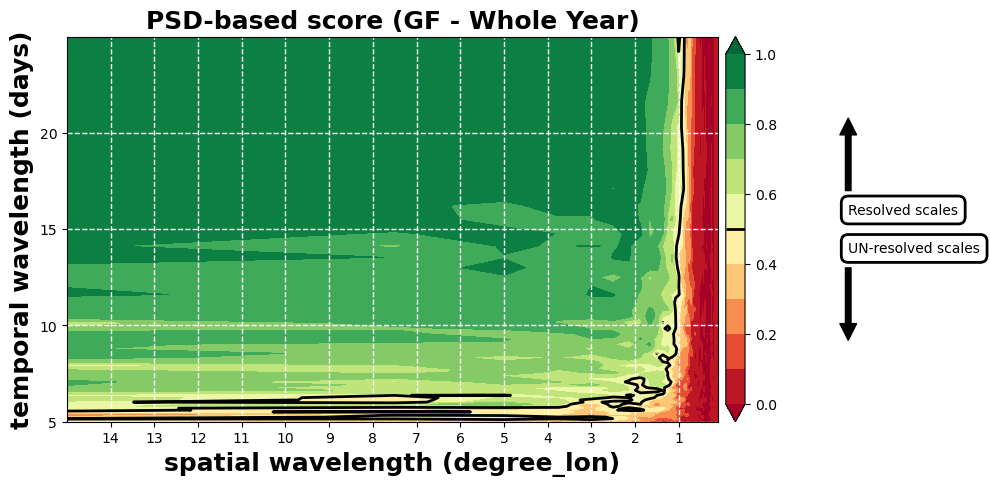

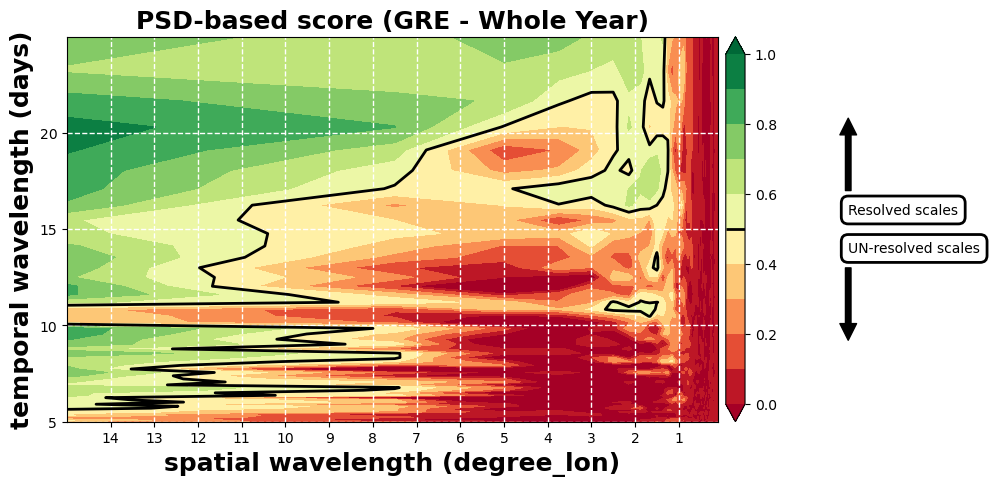

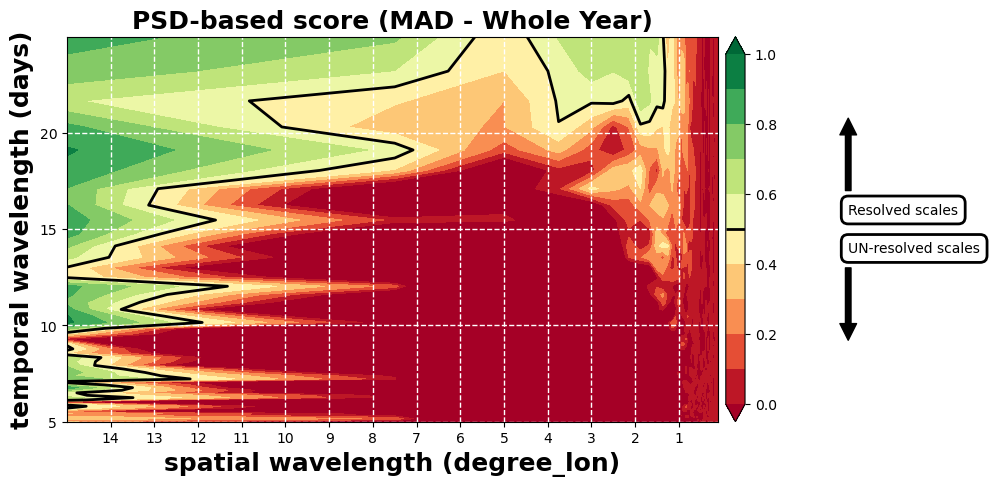

In [11]:
for region in ranges.keys():
    psd[region] = psd[region].expand_dims({'experiment': 1})
    psd[region]['experiment'] = [f'{region} - Whole Year']
    plot_psd_score(psd[region], time_min=5, time_max=25, step_time=5)

The PSD-based score evaluates the spatio-temporal scales resolved in mapping (green area). Resolution limits can be defined as the contour where the PSD score = 0.5, black contour in the figure (i.e. space-time scales where the reconstruction SSH error level is 2 times lower than the real SSH signal). 

### 3.2 Seasonal evaluation 

In [12]:
seasons = ['Mid_autumn', 'Mid_winter', 'Mid_spring', 'Mid_summer']
method = ['4DVarNet','','','']
psd_seasonal = dict()

In [13]:
for region in ranges.keys():
    domain = [region,'','','']
    leaderboard_seasonal = []
    psd_seasonal[region] = []
    data = []

    for i, ds_ref, ds_rec in zip(
        np.arange(len(seasons)), ds_ref_seasonal[region], ds_rec_seasonal[region]
    ):
        # Eval
        rmse_t, rmse_xy, leaderboard_nrmse, leaderboard_nrmse_std = rmse_based_scores(ds_rec, ds_ref)
        psd, leaderboard_psds_score, leaderboard_psdt_score = psd_based_scores(ds_rec, ds_ref)

        psd.name = 'psd_score'

        # Print leaderboard
        data.append([
            method[i],
            domain[i],
            seasons[i],
            leaderboard_nrmse,
            leaderboard_nrmse_std,
            leaderboard_psds_score,
            leaderboard_psdt_score,
        ])
        psd_seasonal[region].append(psd)

    leaderboard_seasonal = pd.DataFrame(
        data,
        columns=([
            'Method',
            'Domain',
            'Season',
            'µ(RMSE) ',
            'σ(RMSE)',
            'λx (degree)',
            'λt (days)',
        ]),
    )

    print('Summary of the leaderboard metrics, for each season:')
    print(leaderboard_seasonal.to_markdown())

[########################################] | 100% Completed | 919.31 ms
[########################################] | 100% Completed | 1.11 sms
[########################################] | 100% Completed | 917.85 ms
[########################################] | 100% Completed | 1.02 sms
[########################################] | 100% Completed | 918.85 ms
[########################################] | 100% Completed | 1.08 sms
[########################################] | 100% Completed | 1.02 sms
[########################################] | 100% Completed | 1.02 sms
Summary of the leaderboard metrics, for each season:
|    | Method   | Domain   | Season     |   µ(RMSE)  |   σ(RMSE) |   λx (degree) |   λt (days) |
|---:|:---------|:---------|:-----------|-----------:|----------:|--------------:|------------:|
|  0 | 4DVarNet | GF       | Mid_autumn |      0.967 |     0.005 |         0.749 |       4.772 |
|  1 |          |          | Mid_winter |      0.957 |     0.004 |         0.894 |   

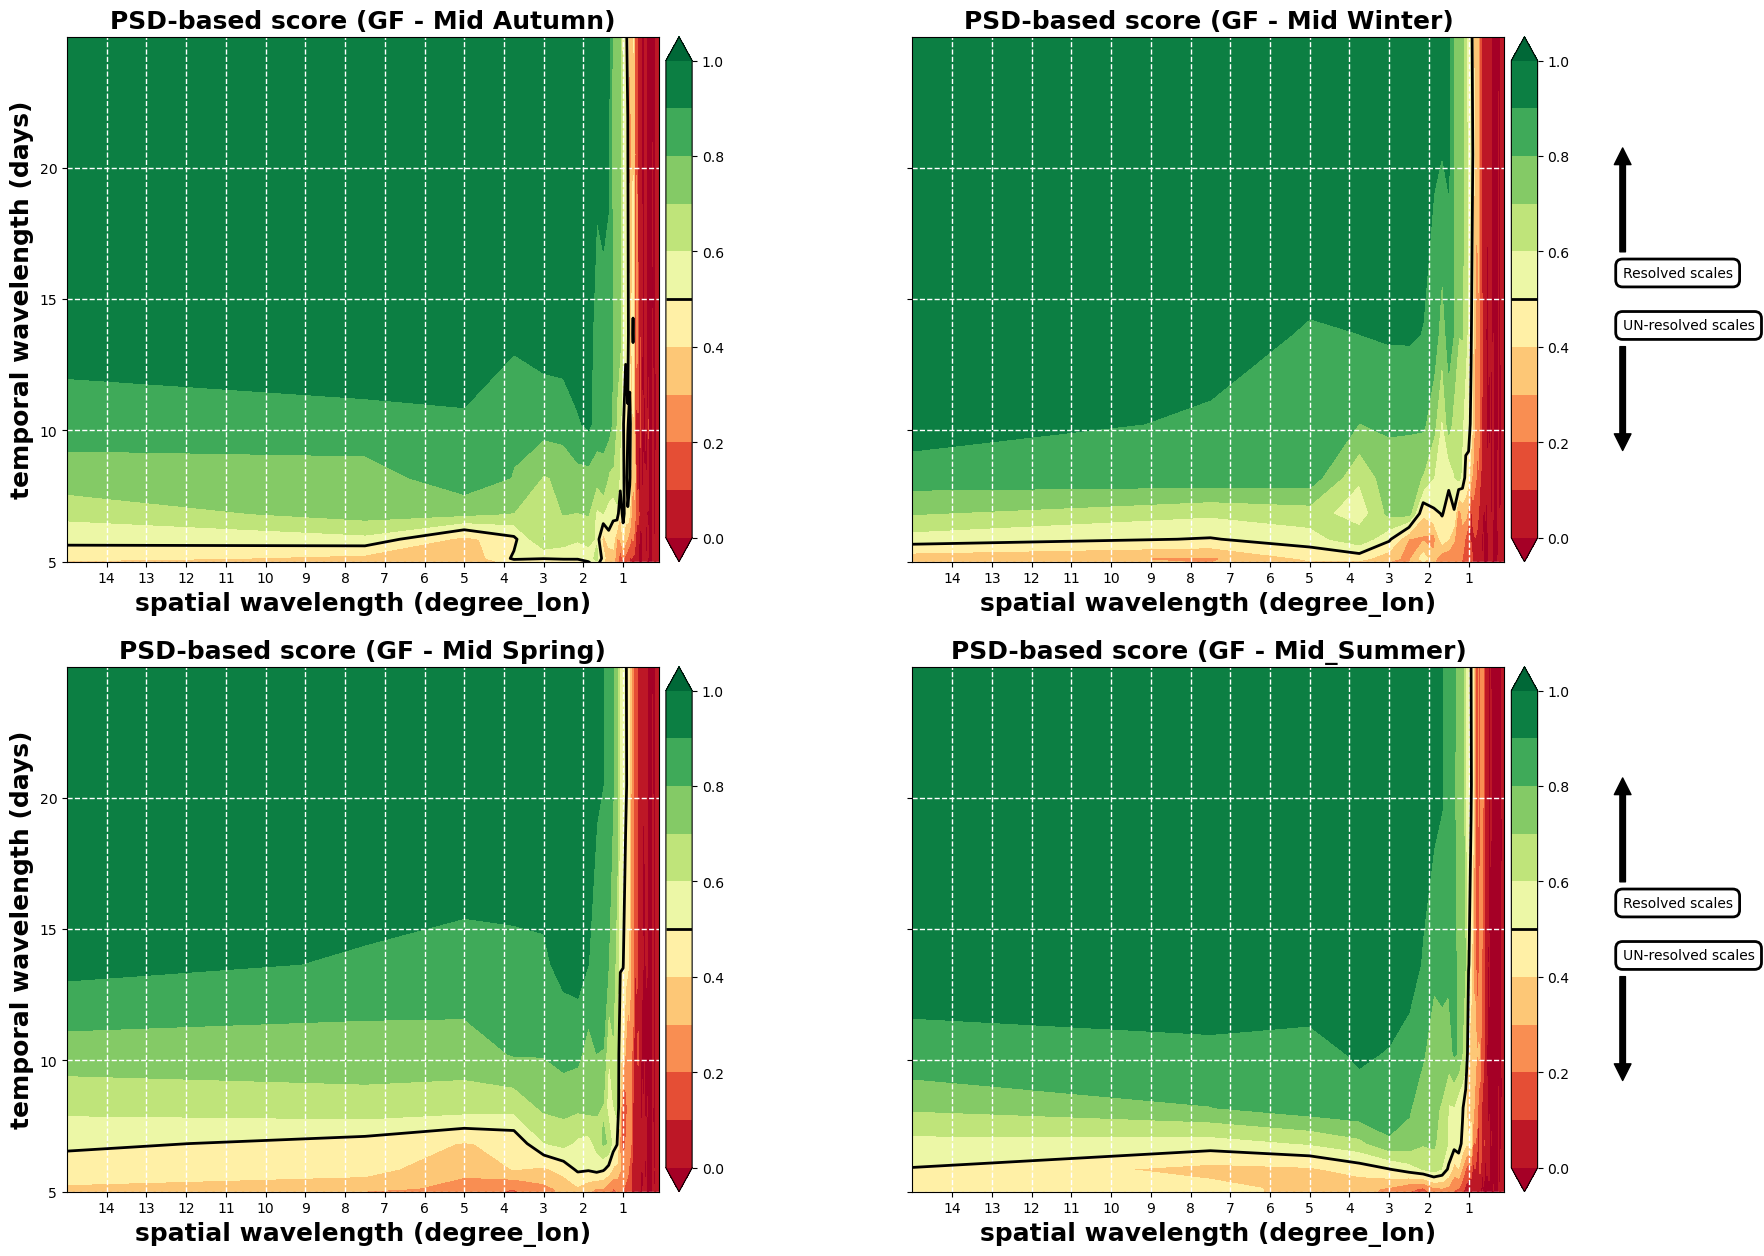

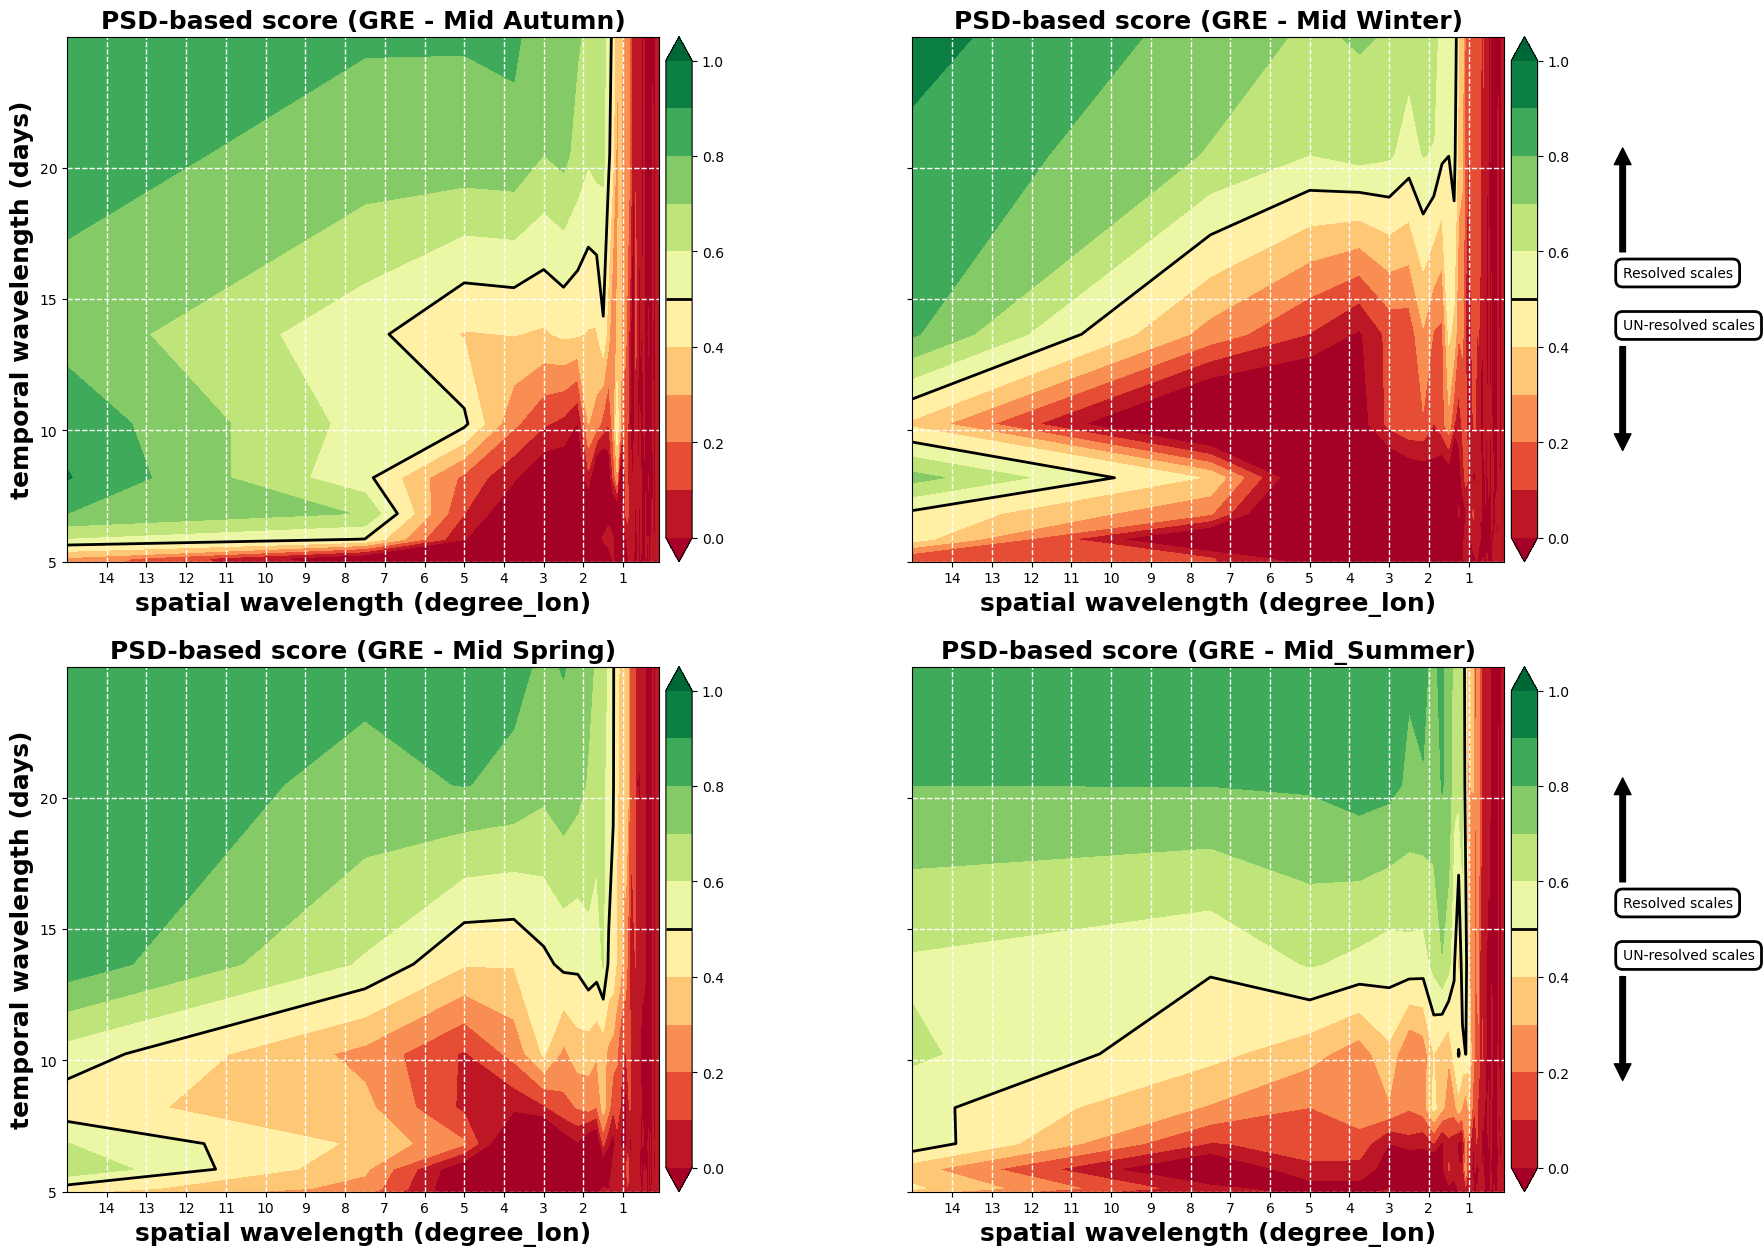

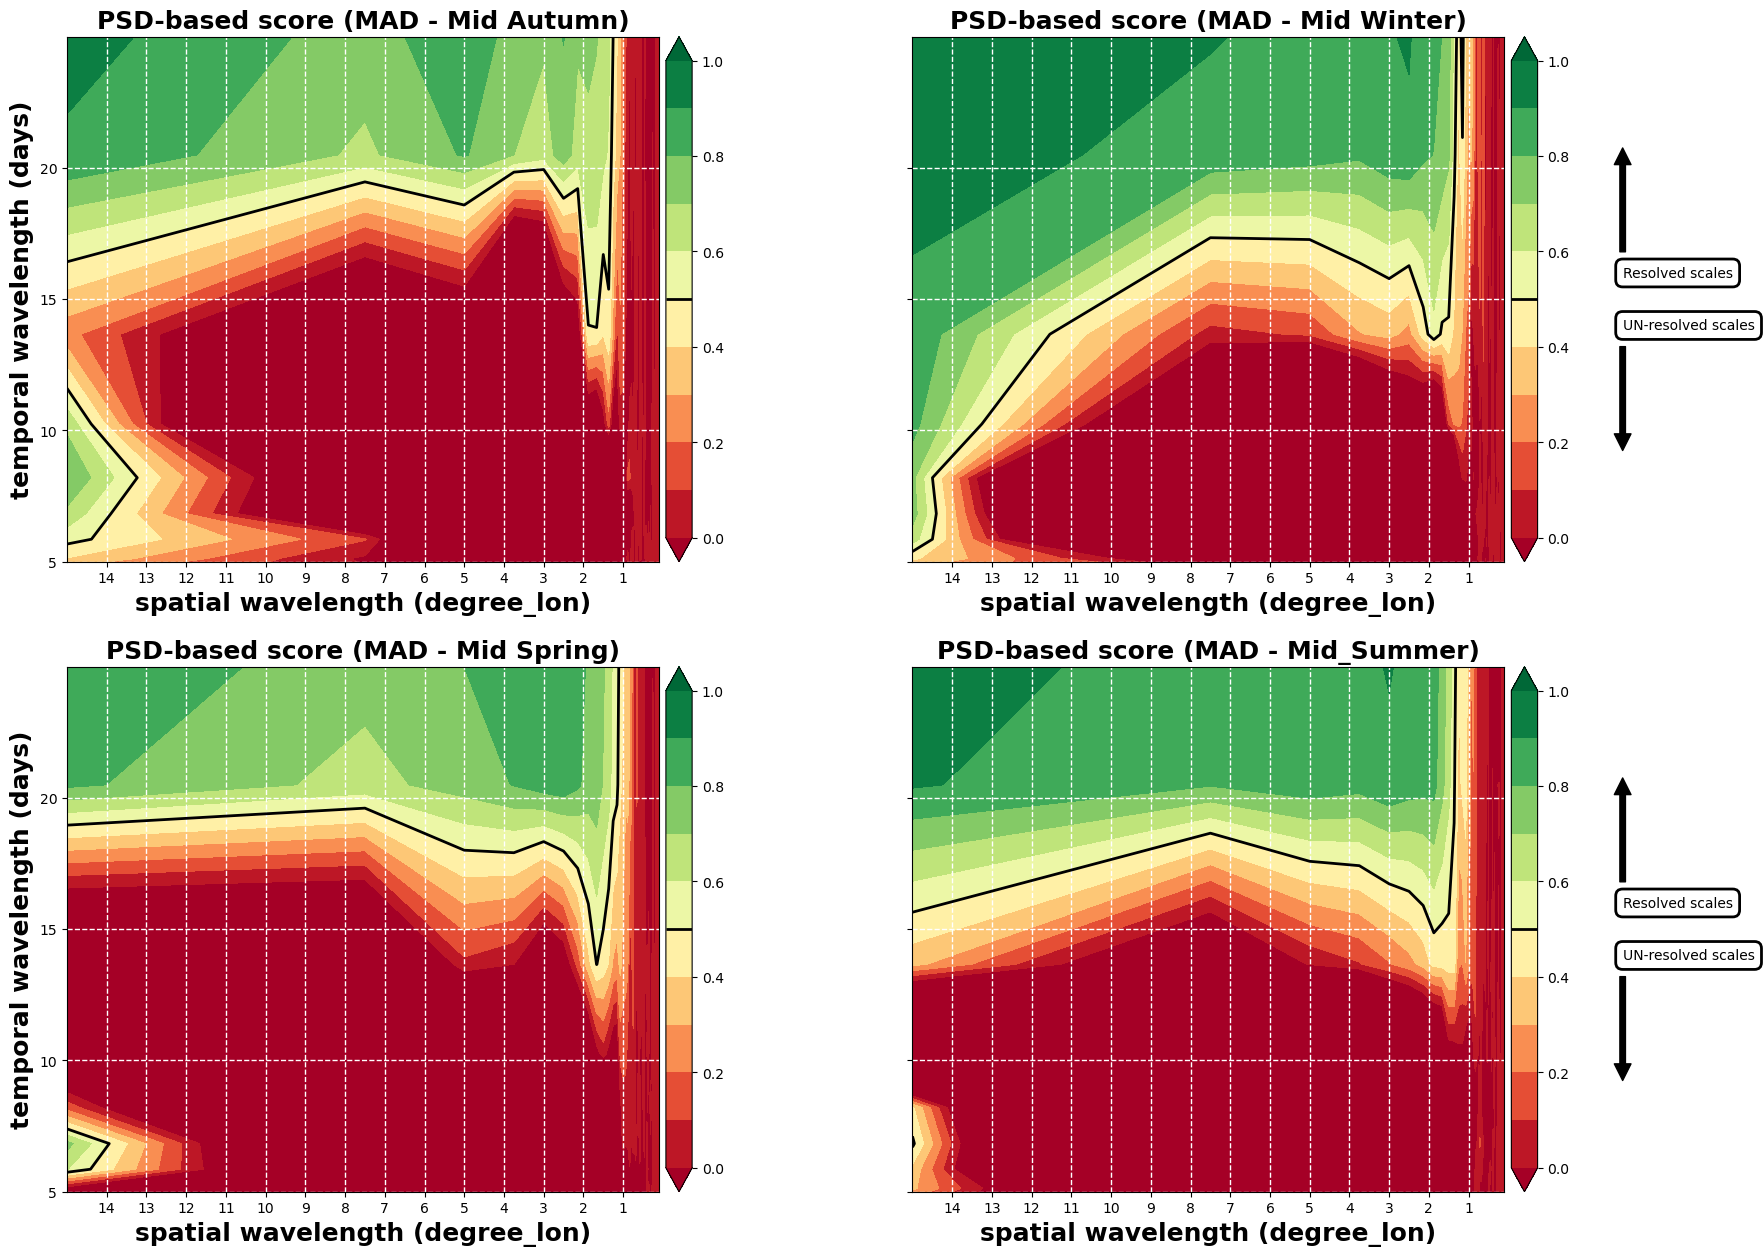

In [14]:
for region in ranges.keys():
    psd_concat = xr.concat(
        (
            psd_seasonal[region][0],
            psd_seasonal[region][1],
            psd_seasonal[region][2],
            psd_seasonal[region][3],
        ),
        dim='experiment',
    )
    psd_concat['experiment'] = [
        f'{region} - Mid Autumn',
        f'{region} - Mid Winter',
        f'{region} - Mid Spring',
        f'{region} - Mid_Summer',
    ]
    plot_psd_score_seasonal(psd_concat, time_min=5, time_max=25, step_time=5)